# **IT5005 Project Milestone 2: Training and Testing on Custom Dataset**

## **📂 Mounting Google Drive & Setting Target Directory**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## **📹 MOT17 Dataset**


The **Multi-Object Tracking (MOT) Dataset** is a widely-used benchmark dataset designed for evaluating algorithms in the field of multi-object tracking, particularly in **pedestrian detection and tracking**. The dataset contains various challenging scenarios, such as crowded scenes, partial occlusions, and various lighting conditions.


## **🔍 MOT17 Dataset Labels (12 Classes)**

The MOT17 dataset uses **12 labels** to represent different categories of objects. These labels are essential for distinguishing between the main targets (pedestrians) and various background or interference objects.

| Label ID | Label Name                     | Description                                           |
|----------|--------------------------------|-------------------------------------------------------|
| 0        | **pedestrian**                 | Primary target: pedestrians walking or standing.     |
| 1        | **Person on vehicle**          | People riding bicycles, motorcycles, or other vehicles. |
| 2        | **Car**                        | All types of cars, including private and public vehicles. |
| 3        | **Bicycle**                    | Bicycles, typically without a rider.                 |
| 4        | **Motorbike**                  | Motorcycles, typically without a rider.              |
| 5        | **Non motorized vehicle**      | Non-motorized vehicles such as carts or wheelchairs. |
| 6        | **Static person**              | People who are stationary, such as sitting or waiting. |
| 7        | **Distractor**                 | Distracting objects unrelated to the primary targets (e.g., billboards, trees). |
| 8        | **Occluder**                   | Objects that partially occlude the targets (e.g., poles, trees). |
| 9        | **Occluder on the ground**     | Ground-based occlusions such as clutter or obstacles. |
| 10       | **Occluder full**              | Objects that fully occlude the target, making it invisible. |
| 11       | **Reflection**                 | False positives caused by reflections on glass, water, etc. |


## **📌 Step 1: Unzip the MOT17 dataset (no need to run this step if it is not a zip file)**

In [ ]:
import zipfile
import os

zip_path = '../MOT17.zip'
extract_path = '/content/drive/MyDrive/Project'#your path
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping is complete!")

Unzipping is complete!


## **📌 Step 2: Convert `gt.txt` (Ground Truth) to YOLO Format Label Files**

In [ ]:
import os
import configparser

def convert_bbox(width, height, left, top, box_width, box_height):
    x_center = (left + box_width / 2) / width
    y_center = (top + box_height / 2) / height
    w = box_width / width
    h = box_height / height

    if x_center > 1: x_center = 1
    if y_center > 1: y_center = 1
    if w > 1: w = 1
    if h > 1: h = 1
    if x_center < 0: x_center = 0
    if y_center < 0: y_center = 0
    if w < 0: w = 0
    if h < 0: h = 0

    return (x_center, y_center, w, h)

def check_and_fix_label(label_values):
    x_center, y_center, w, h = label_values

    if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
        print(f"Warning: Label out of bounds detected! ({x_center}, {y_center}, {w}, {h})")
        x_center = max(0, min(1, x_center))
        y_center = max(0, min(1, y_center))
        w = max(0, min(1, w))
        h = max(0, min(1, h))
        print(f"Fixed label to: ({x_center}, {y_center}, {w}, {h})")

    return x_center, y_center, w, h

root_dir = r'../MOT17.zip'
output_dir_train = os.path.join(root_dir, 'labels', 'train')
output_dir_val = os.path.join(root_dir, 'labels', 'val')
os.makedirs(output_dir_train, exist_ok=True)
os.makedirs(output_dir_val, exist_ok=True)

train_dir = os.path.join(root_dir, 'train')

for sequence in os.listdir(train_dir):
    seq_path = os.path.join(train_dir, sequence)
    gt_path = os.path.join(seq_path, 'gt', 'gt.txt')
    ini_path = os.path.join(seq_path, 'seqinfo.ini')

    if not os.path.exists(gt_path):
        continue

    config = configparser.ConfigParser()
    config.read(ini_path)
    img_width = int(config['Sequence']['imWidth'])
    img_height = int(config['Sequence']['imHeight'])

    with open(gt_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split(',')

        frame_id = int(parts[0])
        left = float(parts[2])
        top = float(parts[3])
        width = float(parts[4])
        height = float(parts[5])
        class_id = int(parts[7]) - 1

        label_values = convert_bbox(img_width, img_height, left, top, width, height)

        x_center, y_center, w, h = check_and_fix_label(label_values)

        if frame_id <= int(config['Sequence']['seqLength']) * 0.8:
            label_path = os.path.join(output_dir_train, f'{sequence}-{frame_id:06d}.txt')
        else:
            label_path = os.path.join(output_dir_val, f'{sequence}-{frame_id:06d}.txt')

        with open(label_path, 'a') as label_file:
            label_file.write(f'{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n')


## **📌 Step 3: Convert MOT Dataset Structure to YOLO Dataset Structure**

### 📁 Original Dataset Structure (MOT17)
The MOT17 dataset is divided into `train` and `test` sets, each containing subfolders for different detectors (e.g., **DPM, FRCNN, SDP**). Each subfolder contains the following:

- `det/`: Detection boxes generated by detectors (usually for baseline evaluation)
- `gt/`: Ground truth labels (this folder exists **only in the train set**)
- `img1/`: Original image sequences (each frame is a single image)

### 🗃️ Expected YOLOv8 Dataset Structure
To make the MOT17 dataset compatible with YOLOv8, it must be restructured as follows:

- `images/`: Stores all images used for training and validation
  - `train/`: Contains 80% of the images for training (`.jpg`)
  - `val/`: Contains 20% of the images for validation (`.jpg`)
- `labels/`: Stores all label files for training and validation
  - `train/`: Contains 80% of the label files for training (`.txt`)
  - `val/`: Contains 20% of the label files for validation (`.txt`)
- `mot_dataset.yaml`: Configuration file for YOLO training, specifying data paths, number of classes, and class names
- `yolo11n.pt`: Pre-trained YOLO model file (trained on the COCO dataset)

### ⚠️ Notes
1. **Image Organization**: Arrange original images in sequential order and place them into `images/train/` and `images/val/`.
2. **Label Organization**: Place the converted label files into `labels/train/` and `labels/val/`.





In [ ]:
import os
import shutil

mot_dir = r'../MOT17.zip'

images_train = os.path.join(mot_dir, 'images', 'train')
images_val = os.path.join(mot_dir, 'images', 'val')

os.makedirs(images_train, exist_ok=True)
os.makedirs(images_val, exist_ok=True)

train_dir = os.path.join(mot_dir, 'train')
for sequence in os.listdir(train_dir):
    img1_path = os.path.join(train_dir, sequence, 'img1')
    if os.path.exists(img1_path):
        for img_file in os.listdir(img1_path):
            old_path = os.path.join(img1_path, img_file)
            new_path = os.path.join(images_train, f"{sequence}-{img_file}")
            shutil.copy(old_path, new_path)

test_dir = os.path.join(mot_dir, 'test')
for sequence in os.listdir(test_dir):
    img1_path = os.path.join(test_dir, sequence, 'img1')
    if os.path.exists(img1_path):
        for img_file in os.listdir(img1_path):
            old_path = os.path.join(img1_path, img_file)
            new_path = os.path.join(images_val, f"{sequence}-{img_file}")
            shutil.copy(old_path, new_path)

## **📌 Step 4: Select Subsets and Split into Training and Validation Sets**

In [ ]:
import os
import shutil
import random

def create_subset(original_dir, output_dir, subset_ratio=0.05, train_ratio=0.8):
    """
    Extract a subset from the original MOT17 dataset and save it to a new directory,
    ensuring images and label files are correctly matched.
    - Images and labels must correspond one-to-one.
    - Ensure images are in sequential frames.
    - Ensure the validation folder is not empty.

    Parameters:
    - original_dir: Root directory of the original dataset (e.g., 'D:/MOT17')
    - output_dir: Output directory for the subset (e.g., 'D:/MOT17_sub')
    - subset_ratio: Ratio of files to extract from the original dataset (default: 0.05 for 5%)
    - train_ratio: Ratio of training data in the extracted subset (default: 0.8 for 80%)
    """
    # Create the output directory
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    # Define the original dataset subfolders
    image_folder = os.path.join(original_dir, 'images/train')
    label_folder = os.path.join(original_dir, 'labels/train')

    # Check that source folders exist
    if not os.path.exists(image_folder) or not os.path.exists(label_folder):
        raise FileNotFoundError("The 'images/train' or 'labels/train' folder does not exist in the original dataset.")

    # Create new output subfolders
    images_train_path = os.path.join(output_dir, 'images/train')
    images_val_path = os.path.join(output_dir, 'images/val')
    labels_train_path = os.path.join(output_dir, 'labels/train')
    labels_val_path = os.path.join(output_dir, 'labels/val')

    for path in [images_train_path, images_val_path, labels_train_path, labels_val_path]:
        os.makedirs(path, exist_ok=True)

    # Get a sorted list of all label files (to ensure sequential frames)
    all_labels = sorted(os.listdir(label_folder))
    total_files = len(all_labels)

    # Calculate the size of the subset
    subset_size = int(total_files * subset_ratio)
    subset_labels = all_labels[:subset_size]  # Take from the beginning to keep frame continuity

    # Calculate the size of the training and validation sets
    train_size = int(len(subset_labels) * train_ratio)
    train_labels = subset_labels[:train_size]
    val_labels = subset_labels[train_size:]

    # Ensure validation set is not empty
    if len(val_labels) == 0:
        raise ValueError("Validation set is empty. Please adjust the subset ratio or check the dataset size.")

    def move_files(label_list, label_dest_path, image_dest_path):
        for label_file in label_list:
            # Copy label file
            label_src_path = os.path.join(label_folder, label_file)
            label_dst_path = os.path.join(label_dest_path, label_file)
            shutil.copy(label_src_path, label_dst_path)

            # Corresponding image file
            image_file = label_file.replace('.txt', '.jpg')
            image_src_path = os.path.join(image_folder, image_file)
            image_dst_path = os.path.join(image_dest_path, image_file)

            if os.path.exists(image_src_path):
                shutil.copy(image_src_path, image_dst_path)
            else:
                print(f"⚠️ Image file {image_src_path} does not exist. Skipping.")

    # Move training files
    move_files(train_labels, labels_train_path, images_train_path)

    # Move validation files
    move_files(val_labels, labels_val_path, images_val_path)

    # Output summary
    print(f"\n✅ Dataset successfully reduced and saved to: {output_dir}")
    print(f"Training set size: {len(train_labels)}")
    print(f"Validation set size: {len(val_labels)}")

# Path to the original dataset (update this to your actual path)
original_mot_dir = r'../MOT17.zip'

# Output path for the subset
output_mot_dir = r'../MOT17_sub_0.5'

# Subset extraction ratio (e.g., 0.05 means 5%)
subset_ratio = 0.5

# Call the function
create_subset(original_mot_dir, output_mot_dir, subset_ratio)


✅ Dataset successfully reduced and saved to: /content/drive/MyDrive/IT5005_Project_1/Milestone_2/MOT17_sub_0.5
Training set size: 5102
Validation set size: 1276


## **📌 Step 5: Install the ultralytics library**

In [ ]:
# !pip install ultralytics -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install ultralytics -i https://mirrors.aliyun.com/pypi/simple

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    F

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.0/112.6 GB disk)


## **📌 Step 6: Load Pretrained YOLO Model, Customize Class Names, and Save Model & YAML Config**

### 📝 Example configuration file: `mot_dataset.yaml`

```
train: /content/drive/MyDrive/MOT17/images/train
val: /content/drive/MyDrive/MOT17/images/val
nc: 12  # 类别数量
names:
  0: pedestrian
  1: Person on vehicle
  2: Car
  3: Bicycle
  4: Motorbike
  5: Non motorized vehicle
  6: Static person
  7: Distractor
  8: Occluder
  9: Occluder on the ground
  10: Occluder full
  11: Reflection

```

In [ ]:
import yaml
from ultralytics import YOLO
import shutil

# 1. Load the pretrained YOLO model
model = YOLO("/content/drive/MyDrive/Project/yolo11n.pt")  # Make sure the model exists at this path

# 2. Modify the number of classes by setting class names for the MOT dataset
model.model.names = {
    0: "pedestrian",
    1: "Person on vehicle",
    2: "Car",
    3: "Bicycle",
    4: "Motorbike",
    5: "Non motorized vehicle",
    6: "Static person",
    7: "Distractor",
    8: "Occluder",
    9: "Occluder on the ground",
    10: "Occluder full",
    11: "Reflection"
}

# 3. Save the updated model weights to the specified path
output_path = '/content/drive/MyDrive/Project/yolo11n_mot.pt'  # Set your desired save path and filename

model.save(output_path)

print(f"✅ Model successfully saved to: {output_path}")

# 4. Create the mot_dataset.yaml file and save it to the specified path
yaml_content = {
    'train': '/content/drive/MyDrive/Project/MOT17_sub_0.5/images/train',
    'val': '/content/drive/MyDrive/Project/MOT17_sub_0.5/images/val',
    'nc': 12,
    'names': {
        0: "pedestrian",
        1: "Person on vehicle",
        2: "Car",
        3: "Bicycle",
        4: "Motorbike",
        5: "Non motorized vehicle",
        6: "Static person",
        7: "Distractor",
        8: "Occluder",
        9: "Occluder on the ground",
        10: "Occluder full",
        11: "Reflection"
    }
}

yaml_path = '/content/drive/MyDrive/Project/mot_dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f"✅ mot_dataset.yaml file successfully saved to: {yaml_path}")

✅ Model successfully saved to: /content/drive/MyDrive/IT5005_Project_1/Milestone_2/yolo11n_mot.pt
✅ mot_dataset.yaml file successfully saved to: /content/drive/MyDrive/IT5005_Project_1/Milestone_2/mot_dataset.yaml


## **📌 Step 7: Train the Model, Log Progress, and Save Trained Weights**

In [ ]:
import os
from ultralytics import YOLO

# 1. Load the customized YOLO model
model = YOLO("../yolo11n_mot.pt")

# 3. Train the model using the custom MOT dataset
model.train(
    data='/content/drive/MyDrive/Project/mot_dataset.yaml',  # Use direct path or variable
    epochs=30,
    batch=32,
    imgsz=640,
    lr0=0.001,
    lrf=0.01,
    optimizer='AdamW',
    name='yolo11n_mot',
    device='cuda',
)

# 4. Save the trained model weights
model_save_path = '/content/drive/MyDrive/Projectyolo11n_mot_trained.pt'
model.save(model_save_path)

print(f"✅ Trained model saved to: {model_save_path}")


Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/IT5005_Project_1/yolo11n_mot.pt, data=/content/drive/MyDrive/IT5005_Project_1/mot_dataset.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolo11n_mot_v43, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt

train: Scanning /content/drive/MyDrive/IT5005_Project_1/MOT17_sub_0.5/labels/train.cache... 5102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5102/5102 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/IT5005_Project_1/MOT17_sub_0.5/labels/val.cache... 1276 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1276/1276 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11n_mot_v43/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11n_mot_v43
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      9.81G       1.57      1.646      1.139       1349        640: 100%|██████████| 160/160 [03:37<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


                   all       1276      15703      0.514      0.145      0.173     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      9.81G      1.163     0.8058     0.9816       1920        640: 100%|██████████| 160/160 [02:41<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


                   all       1276      15703      0.665      0.172      0.189      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      11.4G      1.025     0.6801     0.9416       2115        640: 100%|██████████| 160/160 [02:37<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


                   all       1276      15703      0.437      0.295      0.311      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      11.4G     0.9564     0.6205     0.9219       1234        640: 100%|██████████| 160/160 [02:38<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


                   all       1276      15703      0.716      0.311      0.345      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30        13G     0.8906     0.5747     0.9042       1386        640: 100%|██████████| 160/160 [02:38<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


                   all       1276      15703      0.757       0.34      0.392      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30        13G     0.8558     0.5523     0.8952       1861        640: 100%|██████████| 160/160 [02:38<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


                   all       1276      15703      0.669      0.355      0.396      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       8.3G     0.8306     0.5319      0.888       1634        640: 100%|██████████| 160/160 [02:37<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


                   all       1276      15703      0.676      0.364      0.401       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       8.3G     0.7951     0.5143     0.8814       1348        640: 100%|██████████| 160/160 [02:31<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


                   all       1276      15703      0.518      0.355      0.387      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      9.91G     0.7857     0.5034     0.8773       2179        640: 100%|██████████| 160/160 [02:35<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


                   all       1276      15703      0.615      0.371      0.424      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.91G     0.7635      0.492     0.8725       1685        640: 100%|██████████| 160/160 [02:38<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


                   all       1276      15703      0.795      0.369      0.436      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      9.91G     0.7479     0.4841     0.8696       1533        640: 100%|██████████| 160/160 [02:39<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


                   all       1276      15703      0.595      0.384      0.426      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      9.91G     0.7398     0.4748     0.8663       2300        640: 100%|██████████| 160/160 [02:34<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]

                   all       1276      15703       0.68      0.382      0.441      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      9.91G     0.7266     0.4666     0.8633       1065        640: 100%|██████████| 160/160 [02:34<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


                   all       1276      15703      0.777      0.399      0.458      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      9.91G      0.723     0.4642      0.862       1258        640: 100%|██████████| 160/160 [02:36<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


                   all       1276      15703      0.784      0.397      0.446      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      9.92G     0.6998     0.4532      0.858       1302        640: 100%|██████████| 160/160 [02:36<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


                   all       1276      15703      0.727      0.397      0.448      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      11.5G     0.6922     0.4483     0.8564       1776        640: 100%|██████████| 160/160 [02:36<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


                   all       1276      15703      0.776      0.407      0.436      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      11.5G     0.6851     0.4434     0.8557       1459        640: 100%|██████████| 160/160 [02:38<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


                   all       1276      15703      0.643      0.416      0.453      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      11.5G     0.6751     0.4374     0.8522       1660        640: 100%|██████████| 160/160 [02:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


                   all       1276      15703      0.814      0.408      0.464      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      11.5G     0.6737     0.4343     0.8519       1456        640: 100%|██████████| 160/160 [02:33<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


                   all       1276      15703      0.799      0.419       0.47      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      13.2G     0.6602     0.4298     0.8497       1662        640: 100%|██████████| 160/160 [02:37<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]

                   all       1276      15703      0.777      0.388      0.433      0.317


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      13.2G     0.6337     0.4187     0.8422        989        640: 100%|██████████| 160/160 [02:36<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


                   all       1276      15703      0.806      0.415       0.47      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      13.2G     0.5991     0.3977     0.8351        814        640: 100%|██████████| 160/160 [02:25<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]

                   all       1276      15703       0.82        0.4      0.466       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      13.2G     0.5868     0.3921     0.8328        790        640: 100%|██████████| 160/160 [02:24<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

                   all       1276      15703      0.814      0.426      0.477      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      13.2G     0.5729     0.3838       0.83        946        640: 100%|██████████| 160/160 [02:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]

                   all       1276      15703      0.828       0.43      0.487      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      13.2G     0.5556     0.3768     0.8274        722        640: 100%|██████████| 160/160 [02:27<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

                   all       1276      15703      0.833      0.424      0.493      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      13.2G     0.5514      0.374     0.8253        904        640: 100%|██████████| 160/160 [02:26<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


                   all       1276      15703      0.833      0.435      0.497      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      13.2G     0.5422     0.3698     0.8239        915        640: 100%|██████████| 160/160 [02:23<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]

                   all       1276      15703      0.829      0.439      0.496      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      13.2G     0.5324      0.365     0.8223       1005        640: 100%|██████████| 160/160 [02:23<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]

                   all       1276      15703      0.823      0.444      0.501      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      13.2G     0.5247     0.3607     0.8209        807        640: 100%|██████████| 160/160 [02:23<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]

                   all       1276      15703      0.831      0.448      0.502      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      13.2G      0.519     0.3584       0.82        704        640: 100%|██████████| 160/160 [02:27<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]

                   all       1276      15703      0.835      0.441      0.506      0.408



30 epochs completed in 1.472 hours.
Optimizer stripped from runs/detect/yolo11n_mot_v43/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11n_mot_v43/weights/best.pt, 5.5MB

Validating runs/detect/yolo11n_mot_v43/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


                   all       1276      15703      0.836      0.441      0.506      0.408
            pedestrian       1276      10659      0.949      0.749      0.855      0.643
     Person on vehicle        302        315      0.966      0.781      0.937      0.778
                   Car        133        196      0.835      0.888      0.919      0.697
               Bicycle        301        315      0.943      0.886      0.964      0.788
         Static person        400        400          1          0          0          0
            Distractor        437       1275          1          0     0.0233     0.0135
              Occluder        645       1056      0.993      0.222      0.348      0.343
            Reflection        411       1487          0          0          0          0
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/yolo11n_mot_v43


## **📌 Step 8: Model Validation and Performance Analysis (Includes: Confusion Matrix and Precision-Recall Curve)**

Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/drive/MyDrive/IT5005_Project_1/MOT17_sub_0.5/labels/val.cache... 1276 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1276/1276 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:35<00:00,  2.25it/s]


                   all       1276      15703      0.836      0.441      0.506      0.408
            pedestrian       1276      10659      0.949       0.75      0.855      0.643
     Person on vehicle        302        315      0.967      0.781      0.937       0.78
                   Car        133        196      0.835      0.888      0.919      0.697
               Bicycle        301        315      0.946      0.889      0.966      0.788
         Static person        400        400          1          0          0          0
            Distractor        437       1275          1          0     0.0232     0.0134
              Occluder        645       1056      0.993      0.222      0.348      0.343
            Reflection        411       1487          0          0          0          0
Speed: 0.5ms preprocess, 3.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val


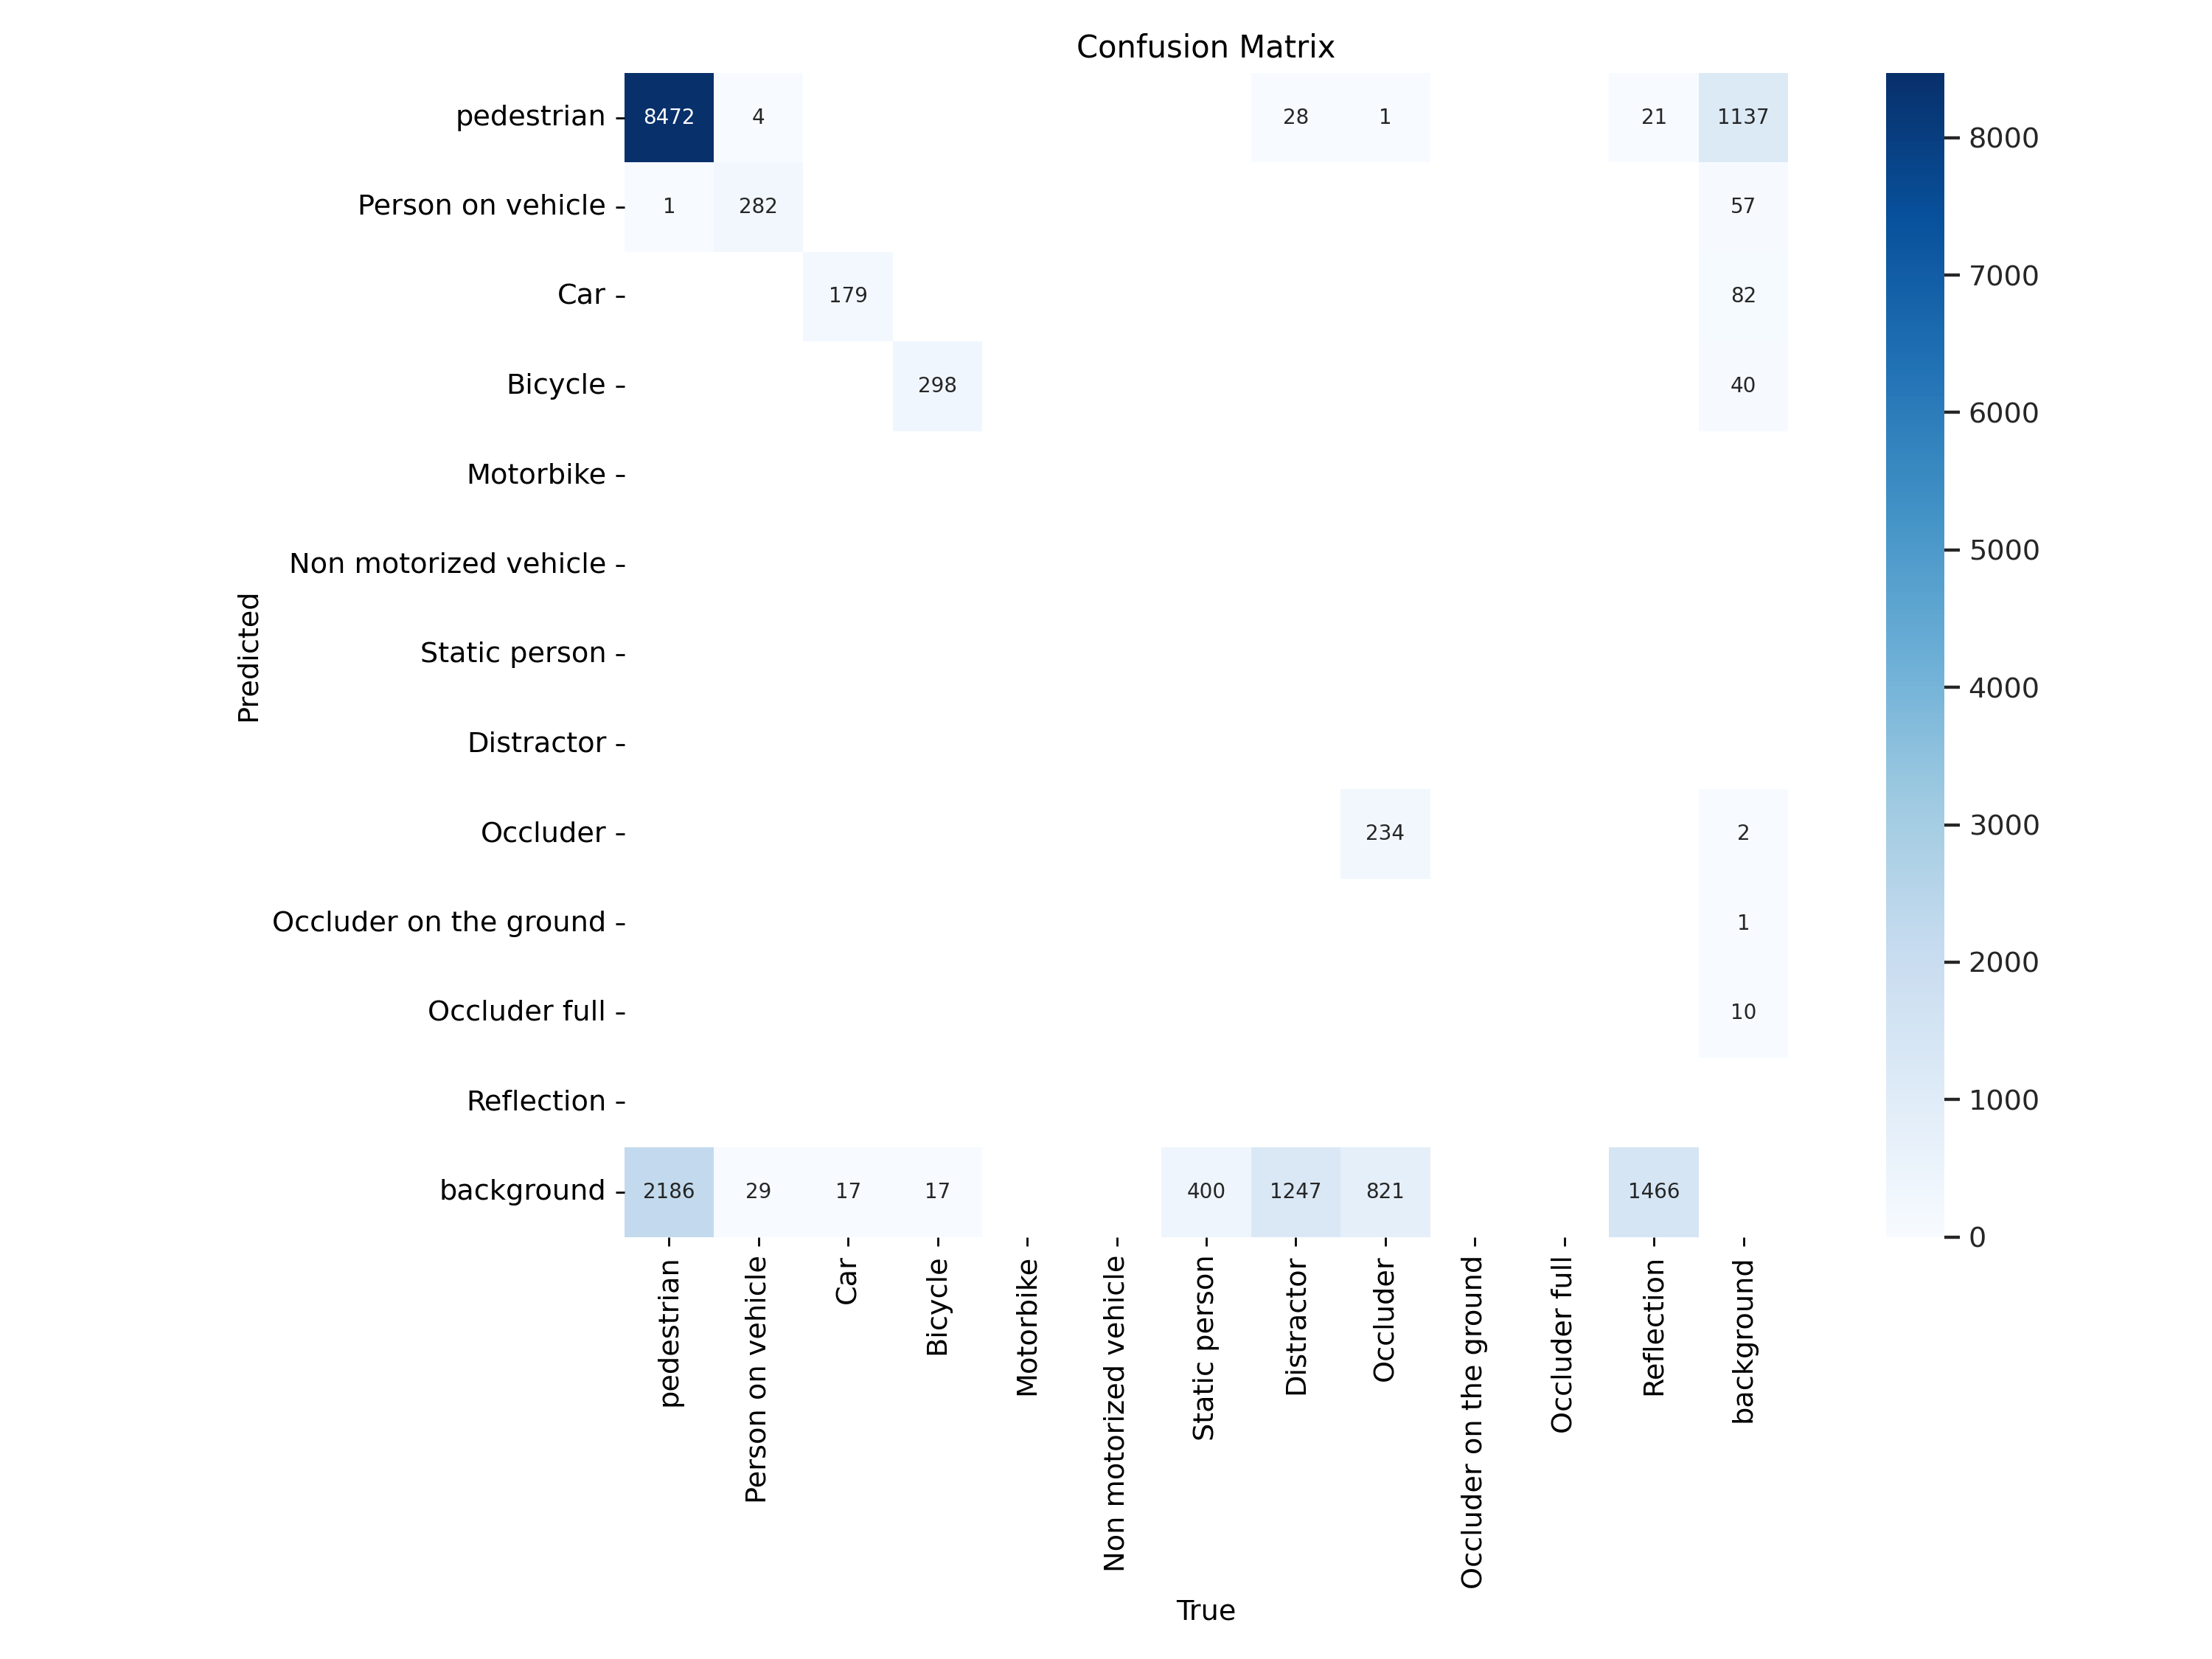

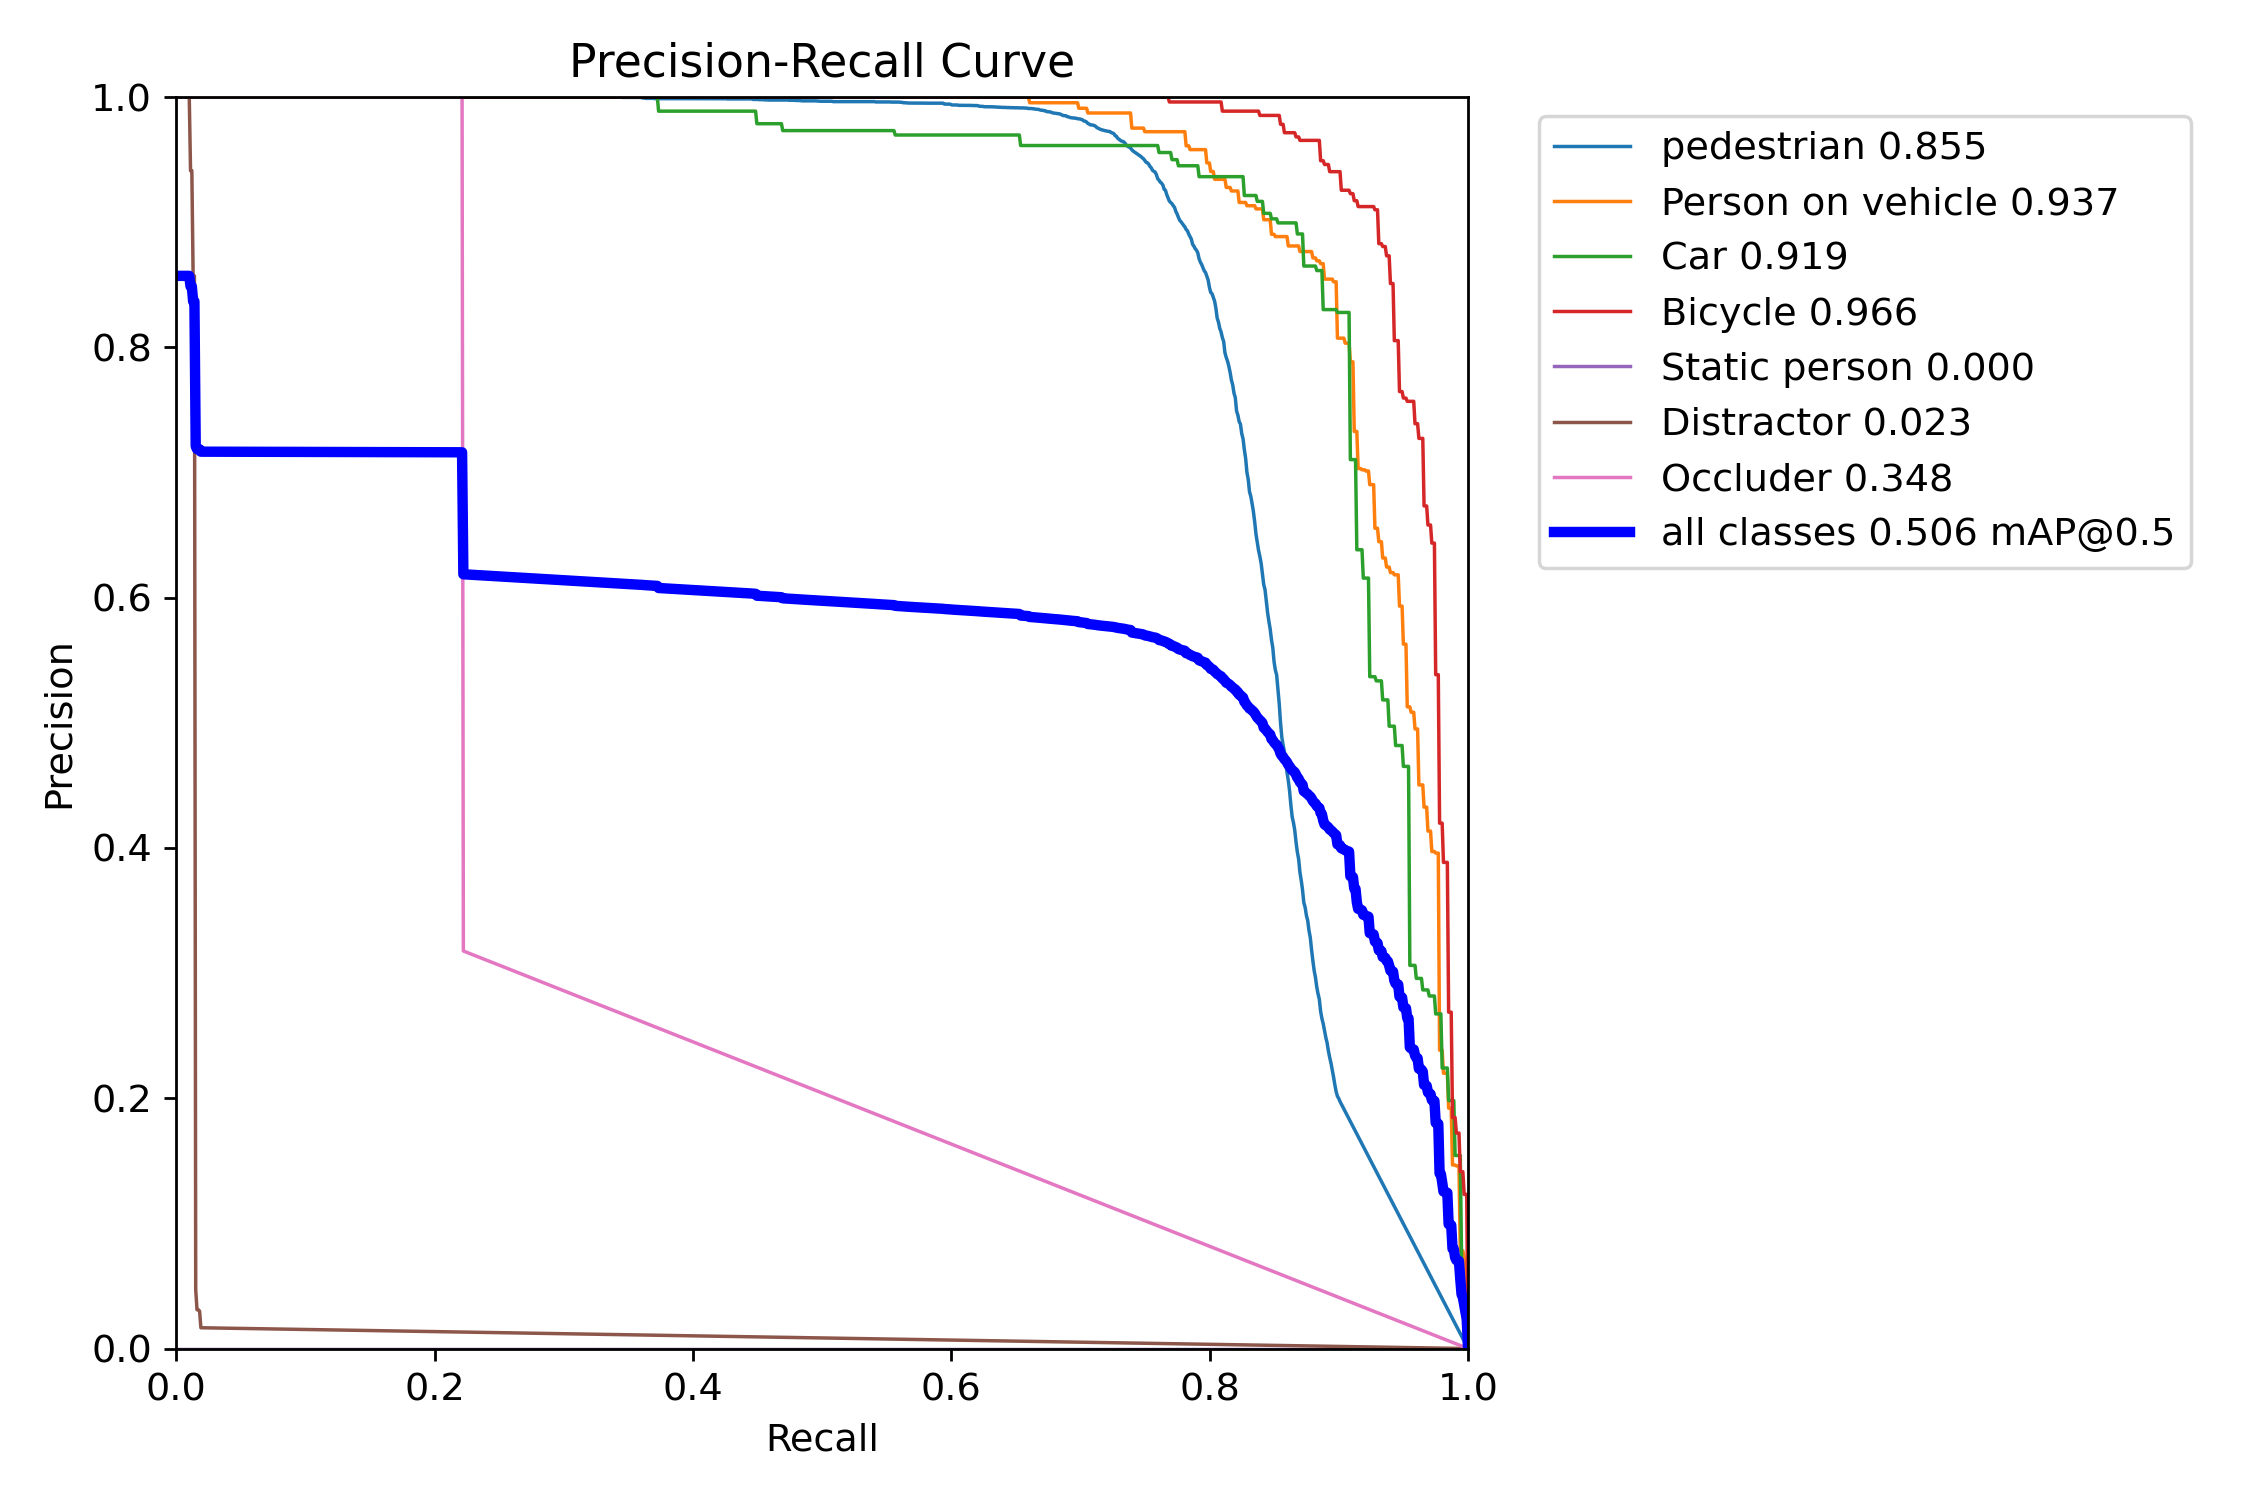

In [ ]:
import os
import logging
import shutil
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Paths configuration
model_path = '/content/drive/MyDrive/Project/yolo11n_mot_trained.pt'
yaml_path = '/content/drive/MyDrive/Project/mot_dataset.yaml'
results_save_dir = '/content/runs/detect/val'
project_dir = '/content/drive/MyDrive/Project/'

# Load the trained model
from ultralytics import YOLO
logging.info("Loading the trained model...")
model = YOLO(model_path)

# Validate the model and save results as JSON
logging.info("Starting model validation...")
results = model.val(
    data=yaml_path,
    device='cuda',
    save_json=True,
    save_dir=results_save_dir
)

logging.info(f"Validation completed. Results have been saved to: {results_save_dir}")

# Paths of the generated images
confusion_matrix_path = Path(results_save_dir) / 'confusion_matrix.png'
pr_curve_path = Path(results_save_dir) / 'PR_curve.png'

# Check if the images exist
if not confusion_matrix_path.exists() or not pr_curve_path.exists():
    raise FileNotFoundError("Confusion matrix or PR curve not found in the results directory.")

# Display the confusion matrix image using IPython display
logging.info("Displaying the confusion matrix image...")
display(IPImage(filename=str(confusion_matrix_path), width=800))

# Display the precision-recall curve image using IPython display
logging.info("Displaying the PR curve image...")
display(IPImage(filename=str(pr_curve_path), width=800))

# Copy the entire results folder to your project directory
destination_dir = Path(project_dir) / 'validation_results'
if destination_dir.exists():
    shutil.rmtree(destination_dir)

shutil.copytree(results_save_dir, destination_dir)

logging.info(f"All files from '{results_save_dir}' have been successfully copied to '{destination_dir}'")


## **📌 Step 9: Validate the model and display the results of the tests**

**Test Video Link:**  https://www.pexels.com/video/people-walking-and-moving-cars-on-the-road-5222540/?utm_source=chatgpt.com

In [ ]:
import os
import logging
import shutil
from pathlib import Path
from ultralytics import YOLO
import cv2
from IPython.display import HTML
from base64 import b64encode

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Paths configuration
model_path = '/content/drive/MyDrive/Project/yolo11n_mot_trained.pt'
video_path = '/content/drive/MyDrive/Project/predict_object_tracking_video.mp4'
output_dir = '/content/drive/MyDrive/Project/video_predict_output'
output_path = os.path.join(output_dir, 'output_video.mp4')
compressed_path = os.path.join(output_dir, 'output_video_compressed.mp4')

logging.info("Loading the trained YOLO model with ByteTrack...")
model = YOLO(model_path)

os.makedirs(output_dir, exist_ok=True)

logging.info("Loading the video...")
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
logging.info(f"Processing video... Total frames: {frame_count}")

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLOv8 + ByteTrack inference on the frame
    results = model.track(source=frame, persist=True, verbose=False)
    annotated_frame = results[0].plot()

    out.write(annotated_frame)
    frame_idx += 1

    if frame_idx % 100 == 0:
        logging.info(f"Processed {frame_idx}/{frame_count} frames")

cap.release()
out.release()
logging.info(f"Video processing completed. Output saved to: {output_path}")

logging.info("Compressing the video for compatibility...")
os.system(f"ffmpeg -y -i '{output_path}' -vcodec libx264 -preset slow -crf 18 '{compressed_path}'")

logging.info("Displaying the processed video...")

mp4 = open(compressed_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=600 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")


Output hidden; open in https://colab.research.google.com to view.